# CS483 Job Bias Course Project
#### Group Members: Om Gor, 
## Data Cleaning/Transformation

In [1]:
from datasets import load_dataset      
import pandas as pd                    
import numpy as np
import re
import string
import matplotlib.pyplot as plt

In [2]:
# Load the dataset by its name from Hugging Face.
ds = load_dataset("LabHC/bias_in_bios")

# Loading the premade split datasets
train_df = ds["train"].to_pandas()
val_df = ds["dev"].to_pandas()
test_df = ds["test"].to_pandas()

In [3]:
# Example of dataset (Train)
train_df

,hard_text,profession,gender
0,He is also the project lead of and major contr...,21,0
1,"She is able to assess, diagnose and treat mino...",13,1
2,"Prior to law school, Brittni graduated magna c...",2,1
3,He regularly contributes to India’s First Onli...,11,0
4,He completed his medical degree at Northwester...,21,0
...,...,...,...
257473,"She photographs advertising images, people in ...",18,1
257474,He is also a graduate of Communications and Me...,24,0
257475,She says one of the first steps in stopping ma...,21,1
257476,He has been photographing for twenty years and...,18,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257478 entries, 0 to 257477
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   hard_text   257478 non-null  object
 1   profession  257478 non-null  int64 
 2   gender      257478 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.9+ MB


In [5]:
print('Missing/NA data in datasets\n')
for data in [train_df, val_df, test_df]:
    print(f"{data.isna().sum()}")
    print("-"*25)

Missing/NA data in datasets

hard_text     0
profession    0
gender        0
dtype: int64
-------------------------
hard_text     0
profession    0
gender        0
dtype: int64
-------------------------
hard_text     0
profession    0
gender        0
dtype: int64
-------------------------


In [6]:
# This cell cleans the biography text and creates a 'text_clean' column.
# Cleaning steps:
# 1. lowercase
# 2. remove numbers
# 3. remove punctuation
# 4. remove extra spaces
# 5. strip spaces at start and end

def clean_text(t):
    # Make sure the input is a string.
    t = str(t)
    # 1. Make all letters lowercase.
    t = t.lower()
    # 2. Remove digits/numbers.
    t = re.sub(r"\d+", " ", t)
    # 3. Remove punctuation marks like . , ? ! etc.
    t = t.translate(str.maketrans("", "", string.punctuation))
    # 4. Replace multiple spaces/newlines with a single space.
    t = re.sub(r"\s+", " ", t)
    # 5. Remove spaces at the beginning and end.
    t = t.strip()
    return t

In [7]:
def clean_df(df):
    df.drop_duplicates(subset=["hard_text", "profession", "gender"])
    df["clean_text"] = df["hard_text"].apply(clean_text)
    
    gender_map = {0: "male", 1: "female"}
    df["gender_str"] = df["gender"].map(gender_map)

    profession_map = {
        0: "accountant", 1: "architect", 2: "attorney", 3: "chiropractor",
        4: "comedian", 5: "composer", 6: "dentist", 7: "dietitian",
        8: "dj", 9: "filmmaker", 10: "interior_designer", 11: "journalist",
        12: "model", 13: "nurse", 14: "painter", 15: "paralegal",
        16: "pastor", 17: "personal_trainer", 18: "photographer",
        19: "physician", 20: "poet", 21: "professor", 22: "psychologist",
        23: "rapper", 24: "software_engineer", 25: "surgeon",
        26: "teacher", 27: "yoga_teacher"
    }
    df['profession_str'] = df["profession"].map(profession_map)
    
    return df[['clean_text', 'profession', 'profession_str', 'gender', 'gender_str']]

train_df_cleaned = clean_df(train_df)
val_df_cleaned = clean_df(val_df)
test_df_clean = clean_df(test_df)

In [8]:
train_df_cleaned.head()

,clean_text,profession,profession_str,gender,gender_str
0,he is also the project lead of and major contr...,21,professor,0,male
1,she is able to assess diagnose and treat minor...,13,nurse,1,female
2,prior to law school brittni graduated magna cu...,2,attorney,1,female
3,he regularly contributes to india’s first onli...,11,journalist,0,male
4,he completed his medical degree at northwester...,21,professor,0,male


In [9]:
# Count how many bios per gender.
gender_counts = train_df_cleaned["gender_str"].value_counts()
gender_props  = train_df_cleaned["gender_str"].value_counts(normalize=True)

print("Gender counts:")
print(gender_counts)
print("\nGender proportions:")
print(gender_props)

Gender counts:
gender_str
male      138780
female    118698
Name: count, dtype: int64

Gender proportions:
gender_str
male      0.538998
female    0.461002
Name: proportion, dtype: float64


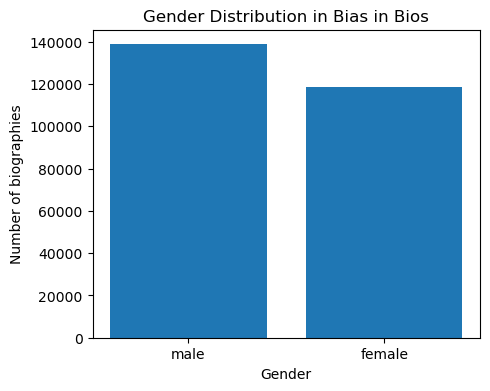

In [10]:
plt.figure(figsize=(5, 4))
plt.bar(gender_counts.index, gender_counts.values)
plt.title("Gender Distribution in Bias in Bios")
plt.xlabel("Gender")
plt.ylabel("Number of biographies")
plt.show()

In [11]:
# This cell looks at how many examples each profession has, and shows the top 10.

# Number of unique professions.
num_prof = train_df_cleaned["profession"].nunique()
print("Number of unique professions:", num_prof)

# Top 10 most common professions by ID.
prof_counts = train_df_cleaned["profession_str"].value_counts().head(10)
print("\nTop 10 profession IDs by count:")
print(prof_counts)

Number of unique professions: 28

Top 10 profession IDs by count:
profession_str
professor       76748
physician       26648
attorney        21169
photographer    15773
journalist      12960
nurse           12316
psychologist    11945
teacher         10531
dentist          9479
surgeon          8829
Name: count, dtype: int64


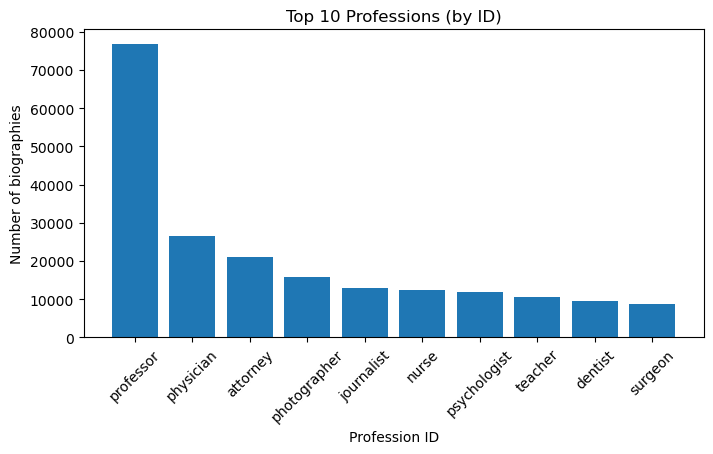

In [12]:
# Plot a bar chart for the top 10 professions.
plt.figure(figsize=(8, 4))
plt.bar(prof_counts.index.astype(str), prof_counts.values)
plt.title("Top 10 Professions (by ID)")
plt.xlabel("Profession ID")
plt.ylabel("Number of biographies")
plt.xticks(rotation=45)
plt.show()

In [13]:
profession_pt = train_df_cleaned.pivot_table(index = 'profession_str', columns = 'gender', values = 'clean_text', aggfunc = 'count')
profession_pt['total'] = profession_pt.sum(axis=1)
profession_pt.loc['Total'] = profession_pt.sum(axis=0)

profession_pt

gender,0,1,total
profession_str,,,
accountant,2317,1343,3660
architect,5014,1554,6568
attorney,13064,8105,21169
chiropractor,1271,454,1725
comedian,1439,385,1824
composer,3042,595,3637
dentist,6133,3346,9479
dietitian,183,2384,2567
dj,828,136,964


<Axes: xlabel='profession_str'>

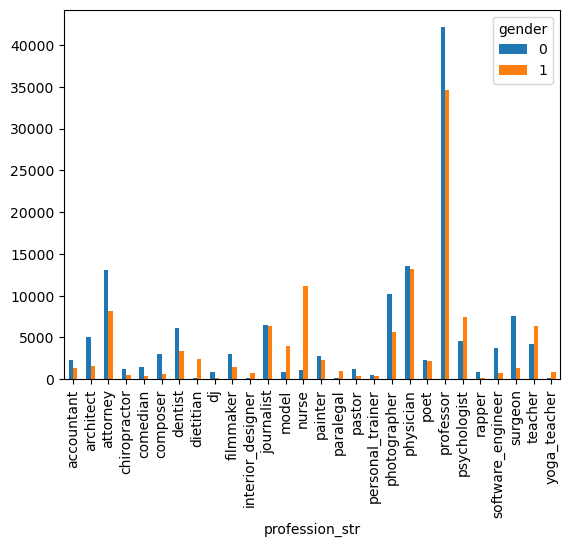

In [14]:
profession_piv = train_df_cleaned.pivot_table(index = 'profession_str', columns = 'gender', values = 'clean_text', aggfunc = 'count')
profession_piv.plot(kind = 'bar')

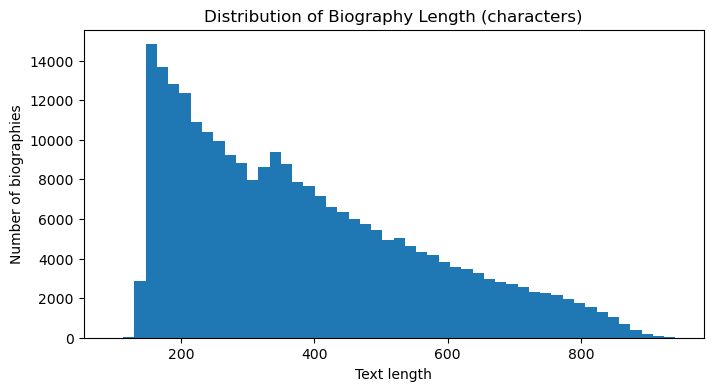

In [15]:
# Show basic statistics about text length.
text_len = train_df_cleaned["clean_text"].str.len()

plt.figure(figsize=(8, 4))
plt.hist(text_len, bins=50)
plt.title("Distribution of Biography Length (characters)")
plt.xlabel("Text length")
plt.ylabel("Number of biographies")
plt.show()

In [16]:
text_len.describe()

count    257478.000000
mean        381.384705
std         182.741579
min          96.000000
25%         227.000000
50%         344.000000
75%         501.000000
max         942.000000
Name: clean_text, dtype: float64

In [17]:
X_train = train_df['clean_text']
y_train = train_df['profession']       
s_train = train_df['gender']           

X_val = val_df['clean_text']
y_val = val_df['profession']
s_val = val_df['gender']


X_test = test_df['clean_text']
y_test = test_df['profession']
s_test = test_df['gender']

In [41]:
# training data exported
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
s_train.to_csv("s_train.csv", index=False)

# val data exported
X_val.to_csv("X_val.csv", index=False)
y_val.to_csv("y_val.csv", index=False)
s_val.to_csv("s_val.csv", index=False)

# test data exported
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
s_test.to_csv("s_test.csv", index=False)